In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import awkward as ak
import uproot
import hist
import numpy as np
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.processor import dict_accumulator, list_accumulator

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5
import itertools
import json

# for making fancy 2d histograms
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from utils import (plot_1d_trigger_efficiencies, 
                plot_1d_trigger_efficiencies_improvement, 
                plot_fancy_2d_trigger_efficiencies, 
                compare_trigger_efficiencies, 
                plot_cutflow,
                plot_1d_trigger_soup_compact,
                plot_1d_trigger_soup_cms)
from trig_eff_process import (create_baseline_selection_mask, 
                            TriggerEfficiencyProcessor, 
                            TriggerEfficiencyImprovementProcessor, 
                            VBFBaselineCutFlowProcessor, 
                            GeneralBaselineCutFlowProcessor,
                            TriggerSoupProcessor)

In [2]:
trig_vars = {
    'ht': {
        'label': "H_{T} [GeV]",
        'axis': hist.axis.Regular(bins=100, start=0, stop=2000, name="ht", label="H_{T} [GeV]"),
        'proc': lambda events: ak.sum(events.FatJet.pt, axis=1)
    },
    'pt': {
        'label': "Leading Jet $p_{T}$ [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="pt", label="Leading Jet $p_{T}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.pt, 1, clip=True)[:, 0], np.nan)
    },
    'msd': {
        'label': "Leading Jet $m_{SD}$ [GeV]",
        'axis': hist.axis.Regular(bins=10, start=40, stop=200, name="msd", label="Leading Jet $m_{SD}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.msoftdrop, 1, clip=True)[:, 0], np.nan)
    },
    'num_ak4': {
        'label': "Number of AK4 Jets",
        'axis': hist.axis.Integer(0, 20, name="num_ak4", label="Number of AK4 Jets"),
        'proc': lambda events: ak.num(events.Jet)
    },
    'gen_H_pt': {
        'label': "Gen Higgs pT [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="gen_H_pt", label="Gen Higgs pT [GeV]"),
        'proc': lambda events: events.HTXS.Higgs_pt
    },
    'particleNet_XbbVsQCD':{
        'label': "Leading Particle Net TXbb score",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1, name="particleNet_XbbVsQCD", label="Leading Particle Net TXbb score"),
        'proc': lambda events: ak.fill_none(
            ak.pad_none(events.FatJet.particleNet_XbbVsQCD, 1, clip=True)[:, 0],
            np.nan
        )
    }
}


Currently processing production mode VBF
trigger_combinations: [['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40'], ['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40', 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1'], ['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40', 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1', 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65']]


Output()

Output()

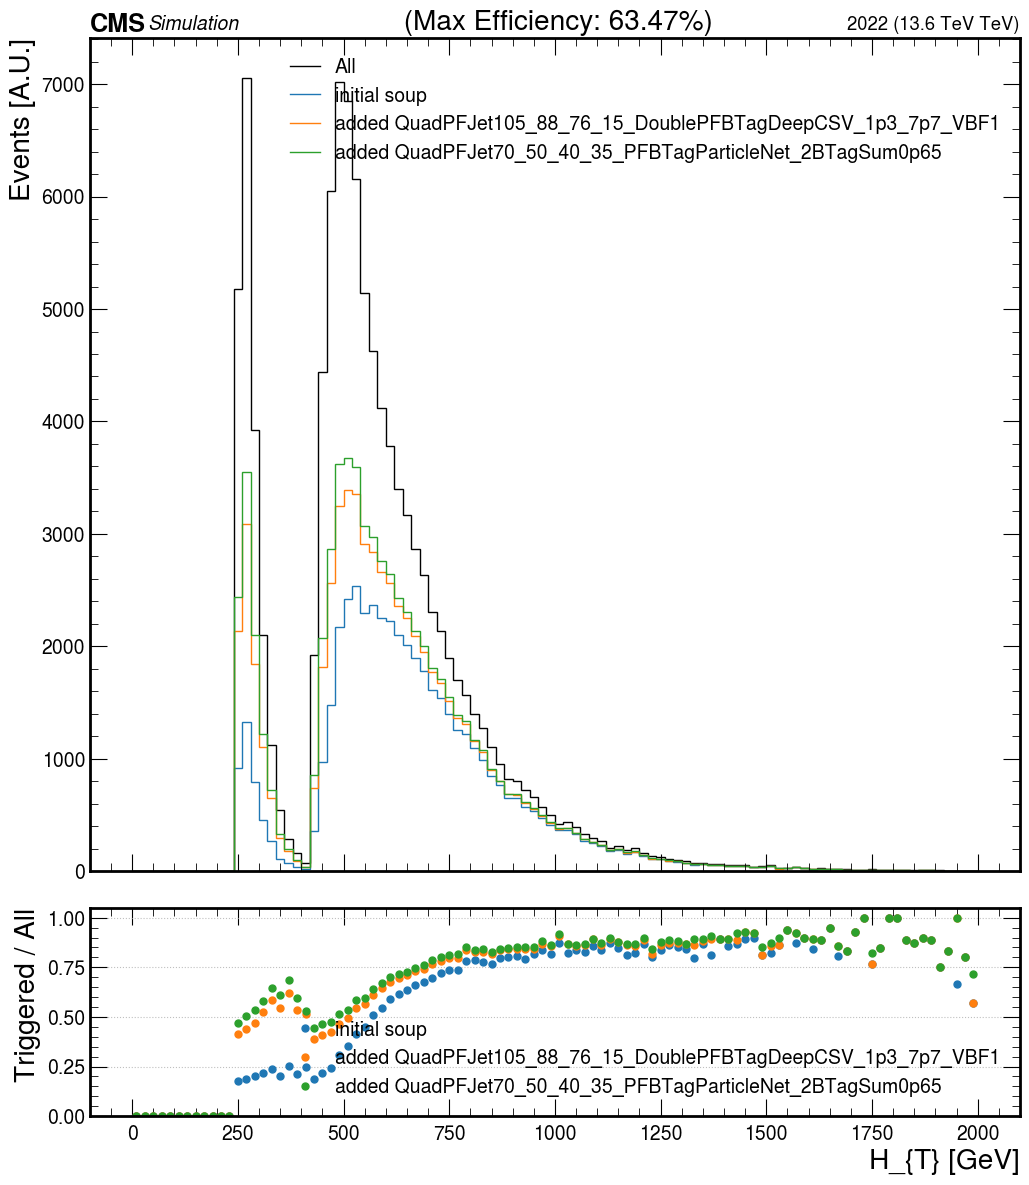

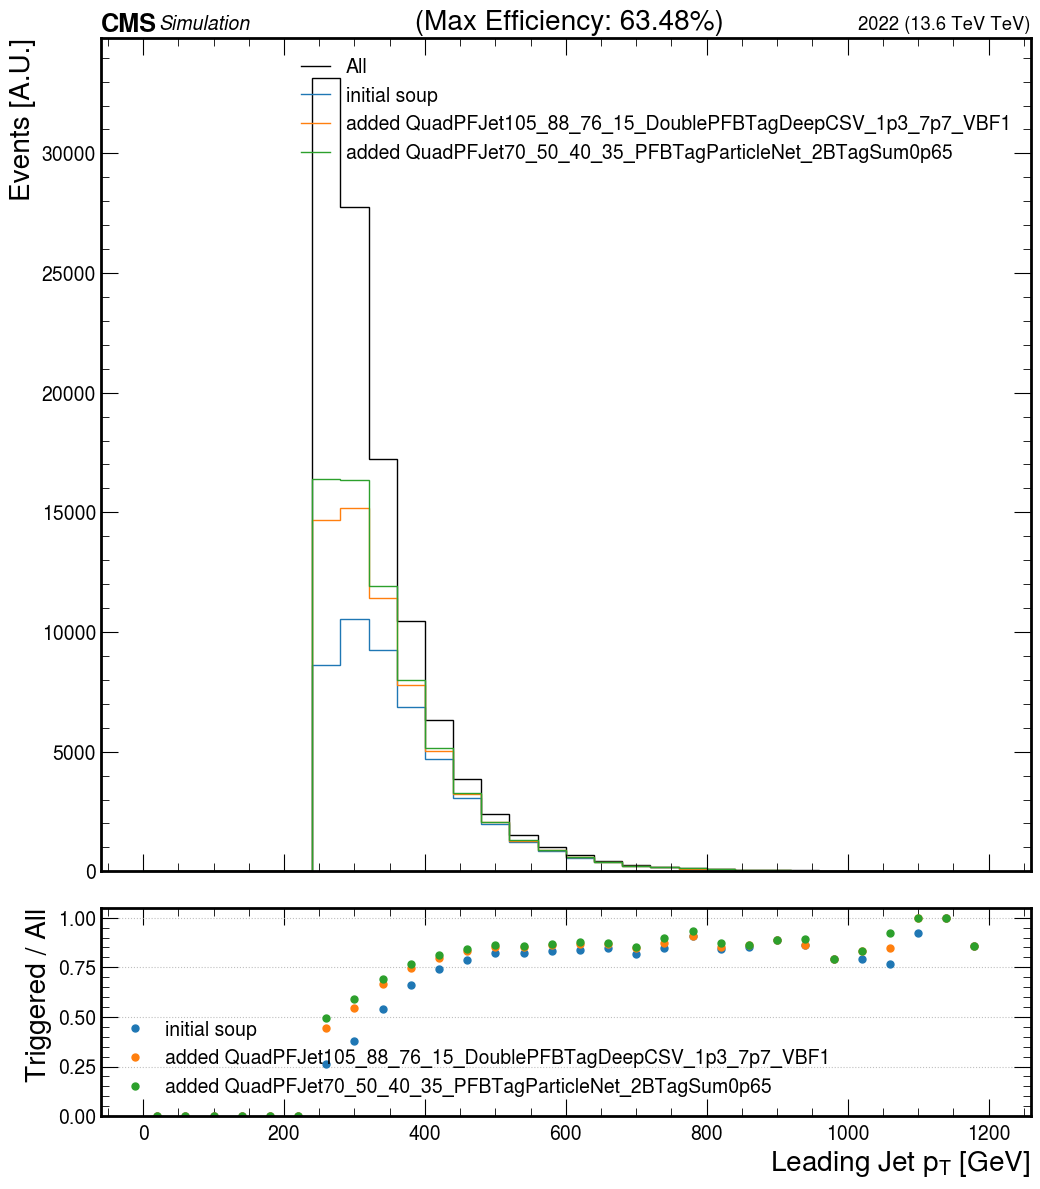

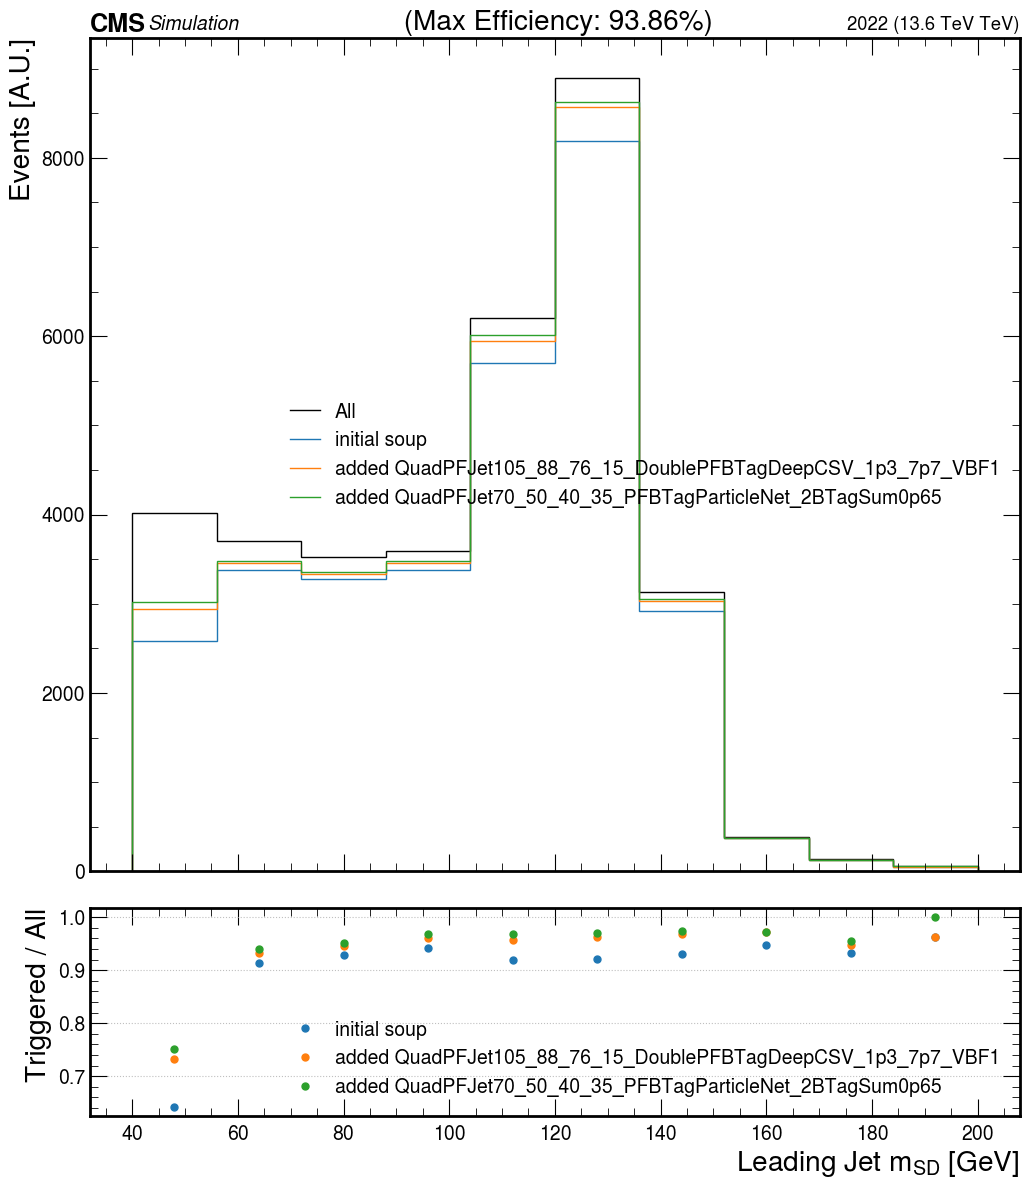

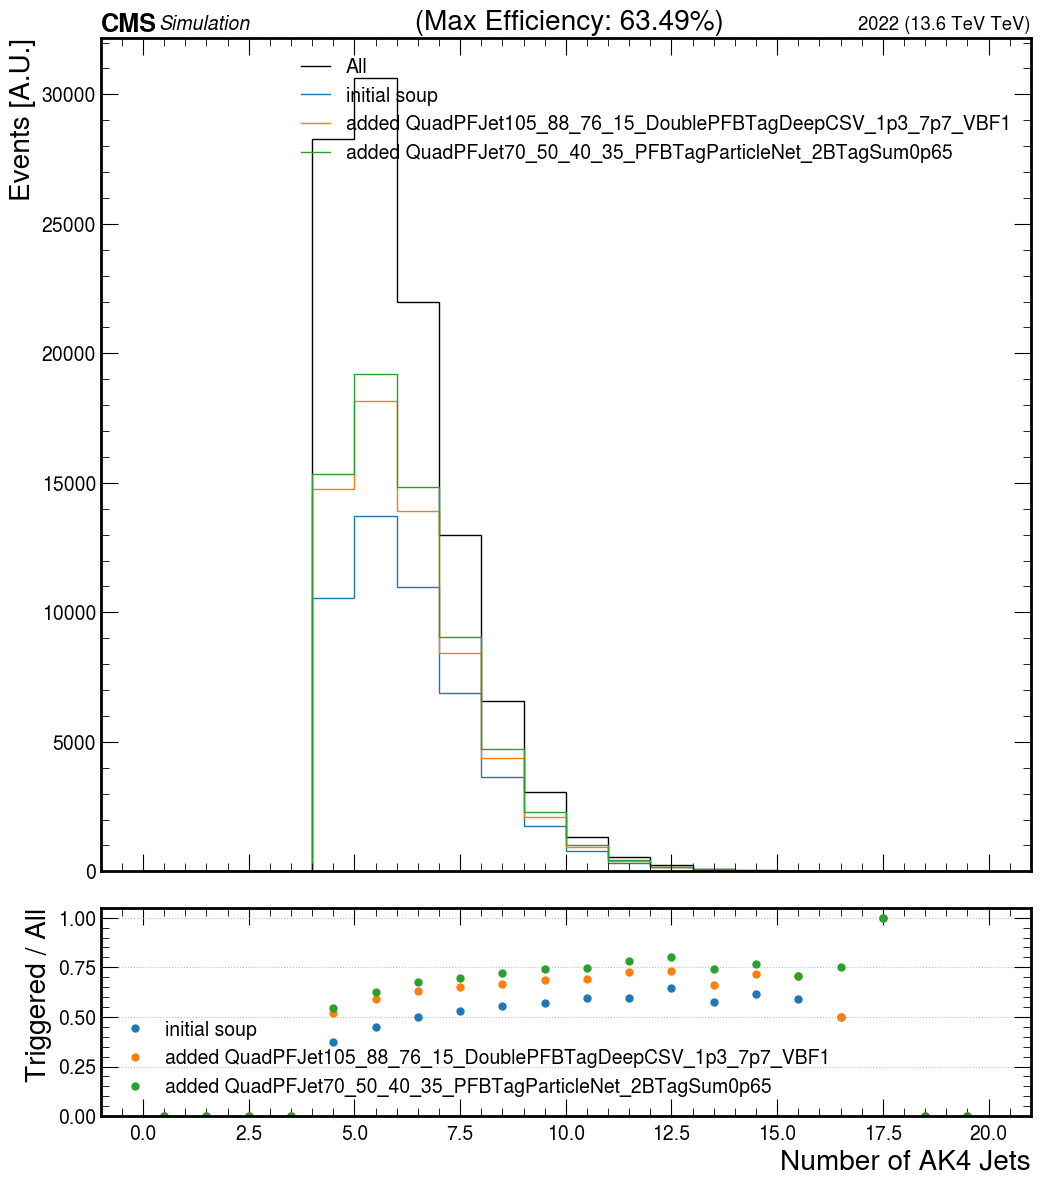

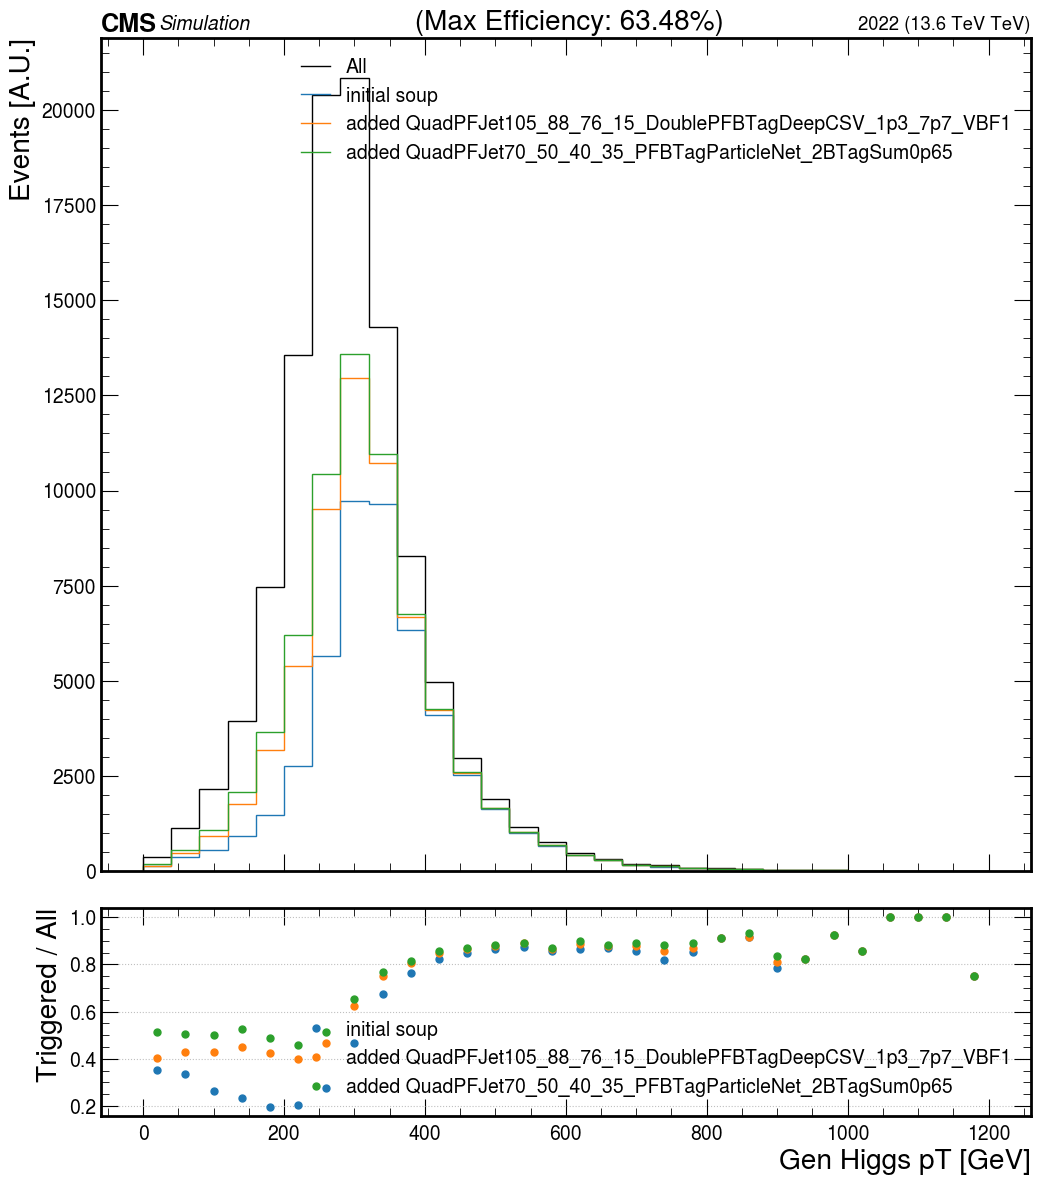

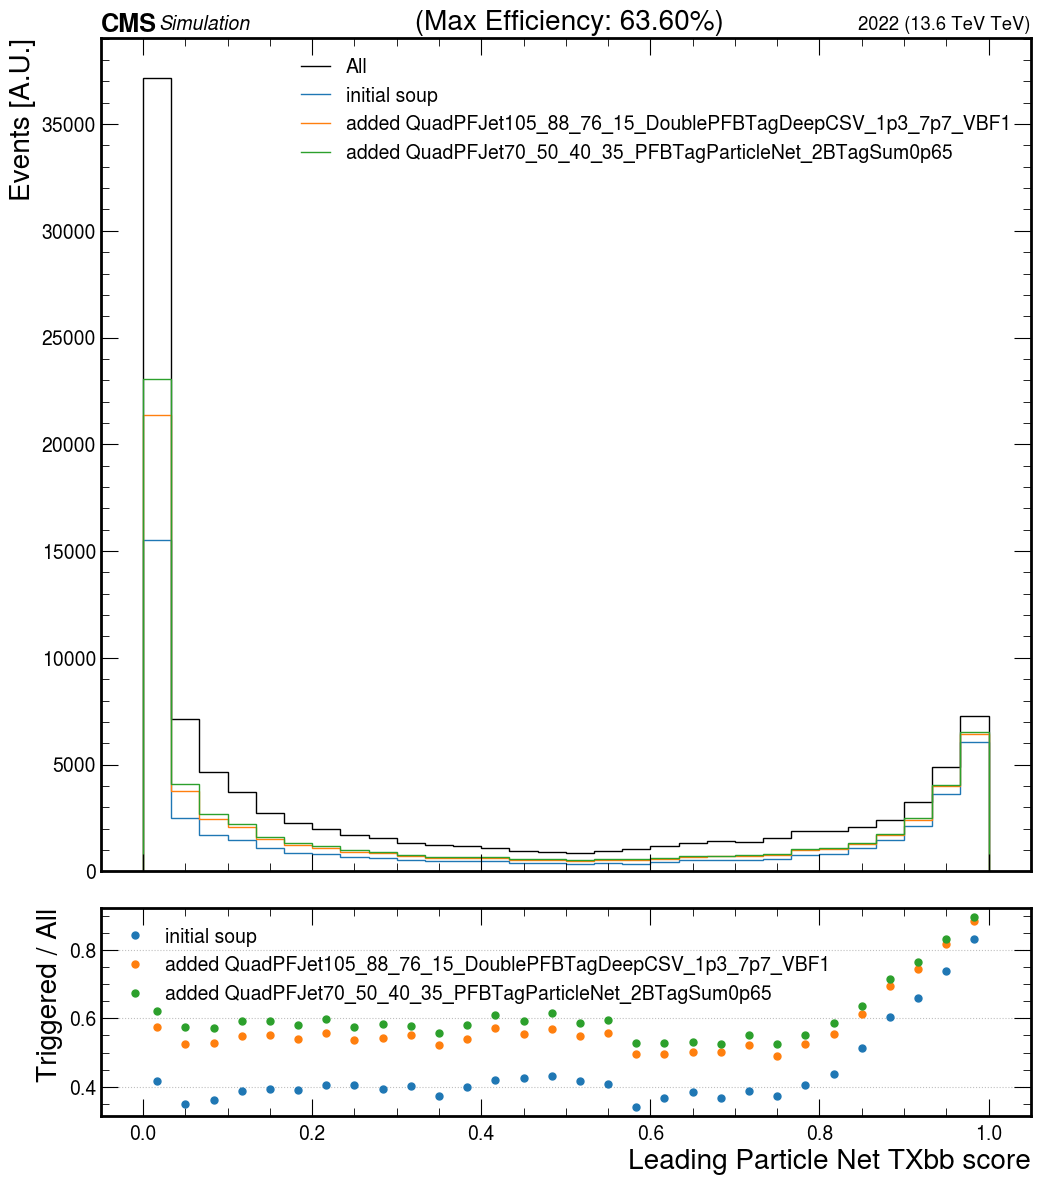

Currently processing production mode ggF
trigger_combinations: [['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40'], ['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40', 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1'], ['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40', 'QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1', 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65']]


Output()

Output()

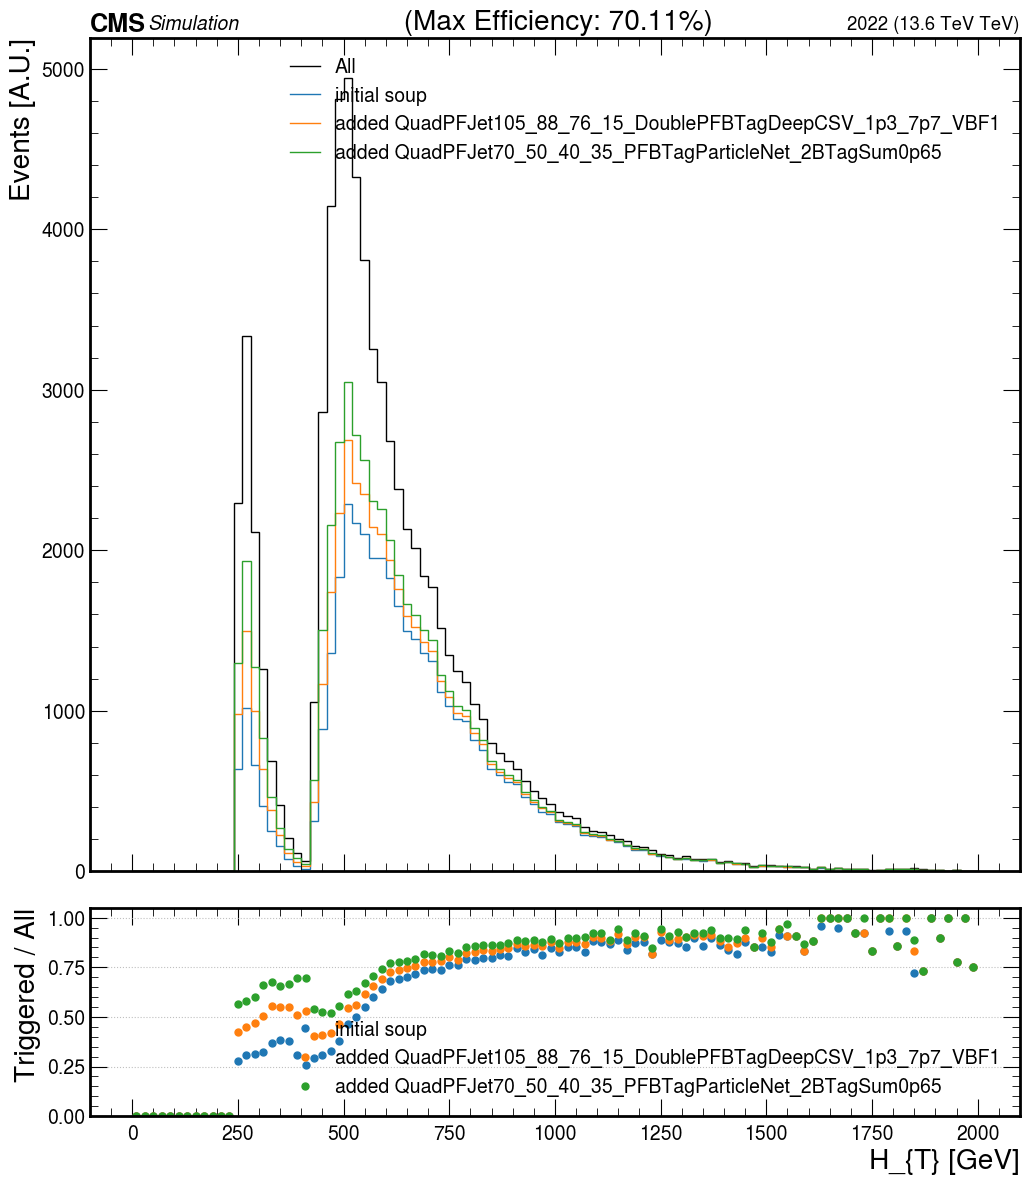

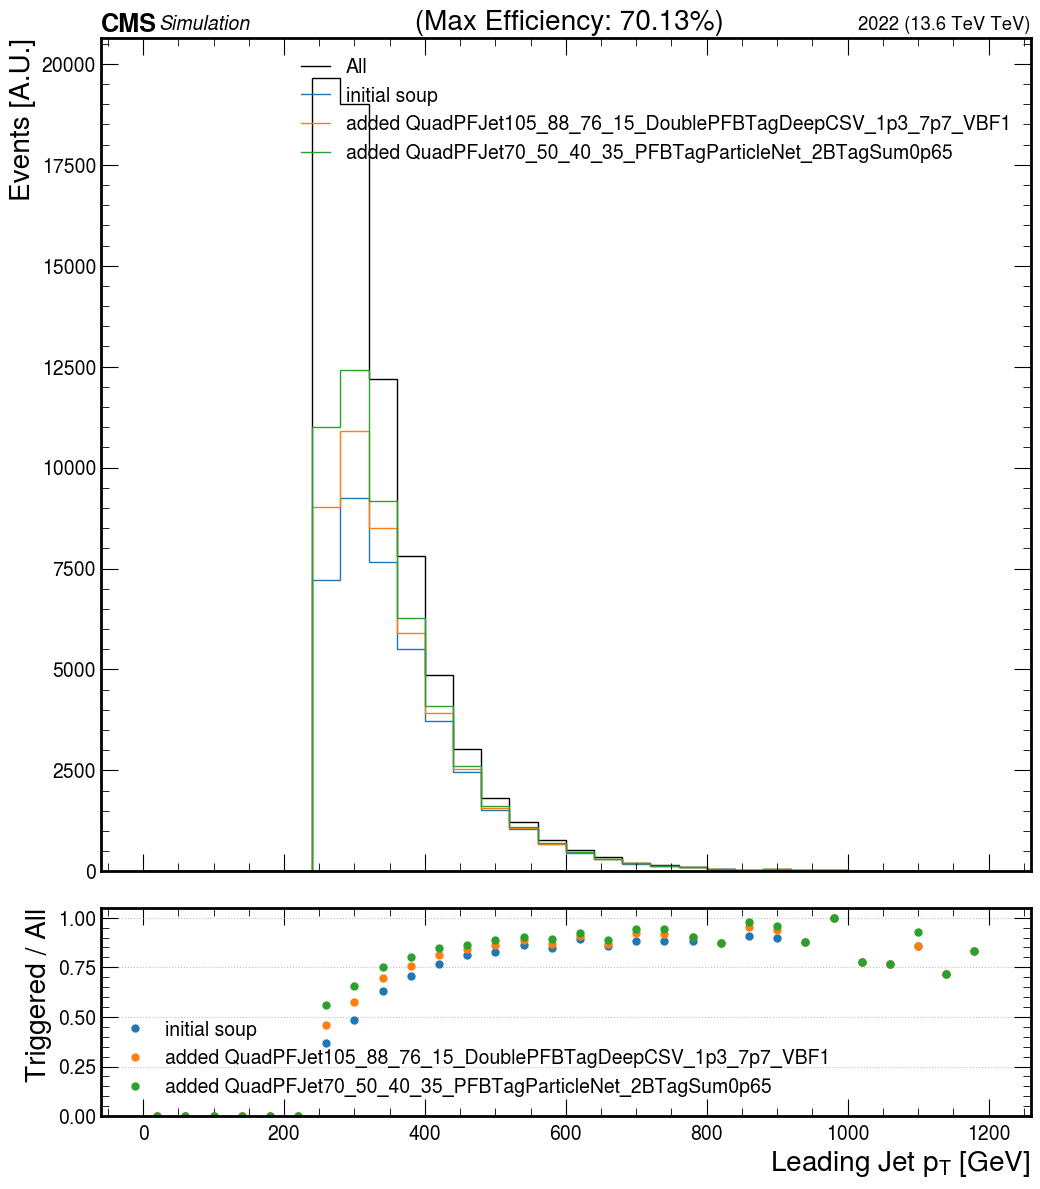

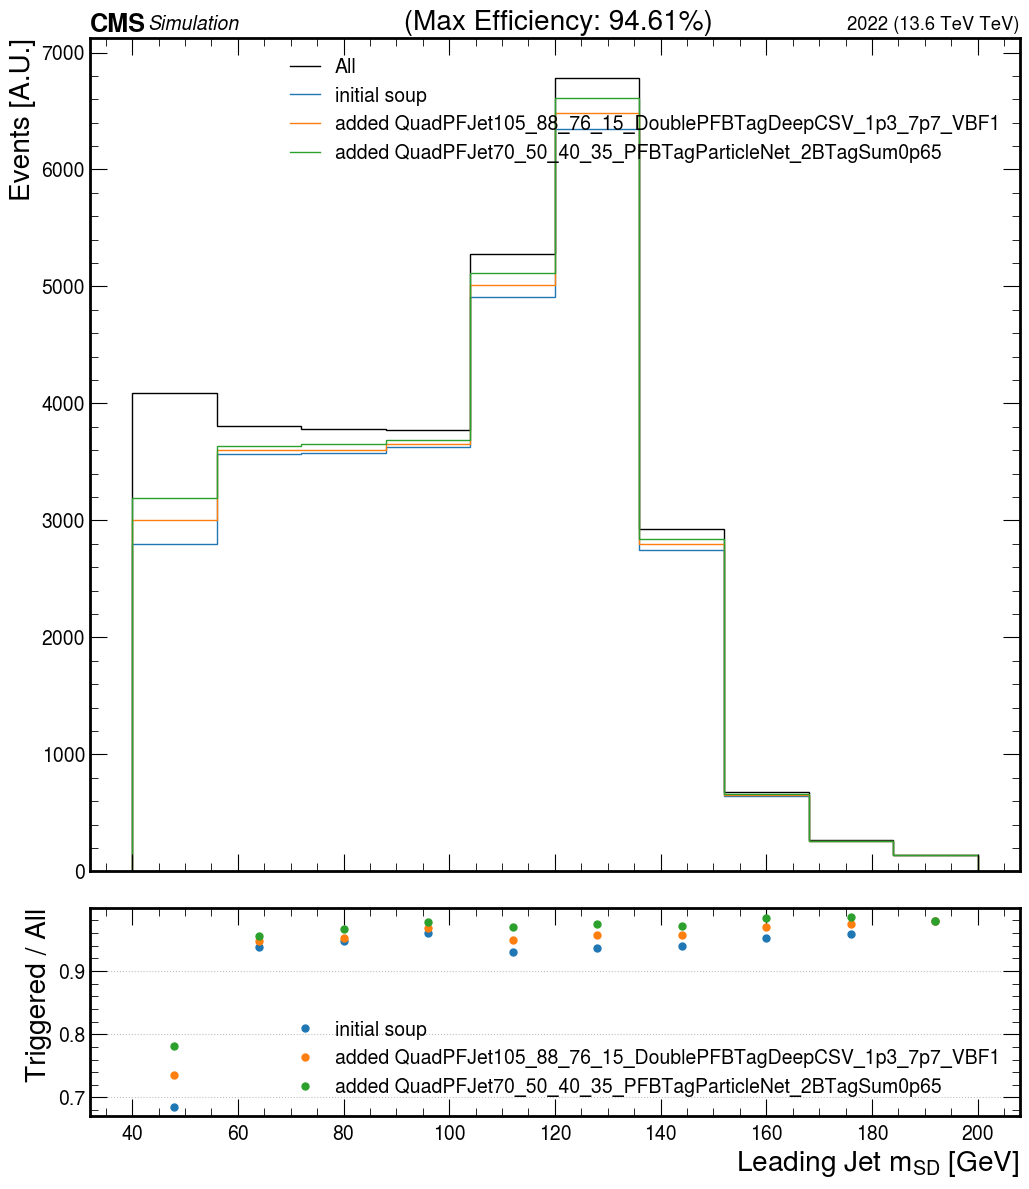

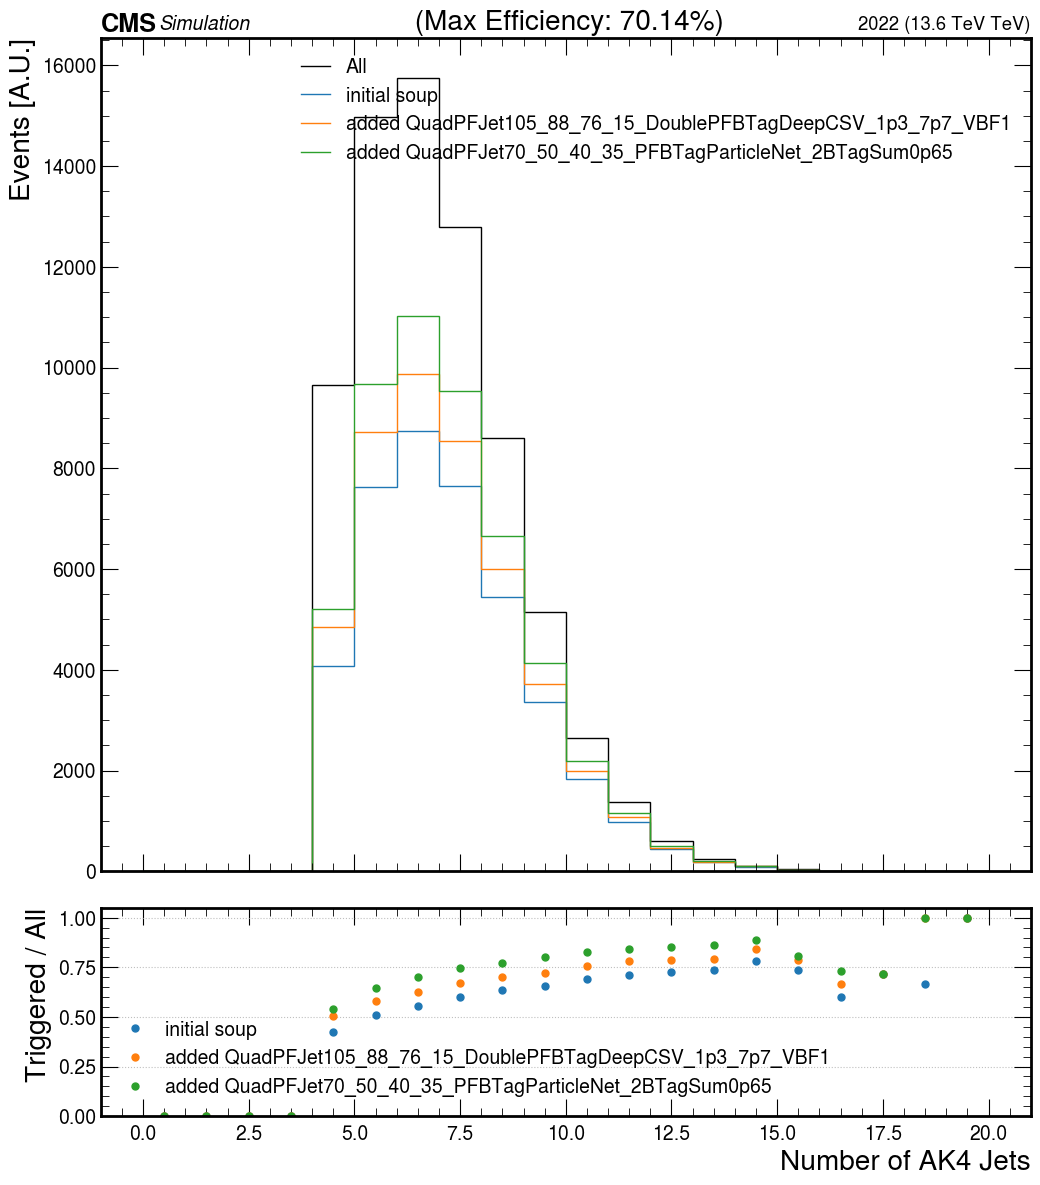

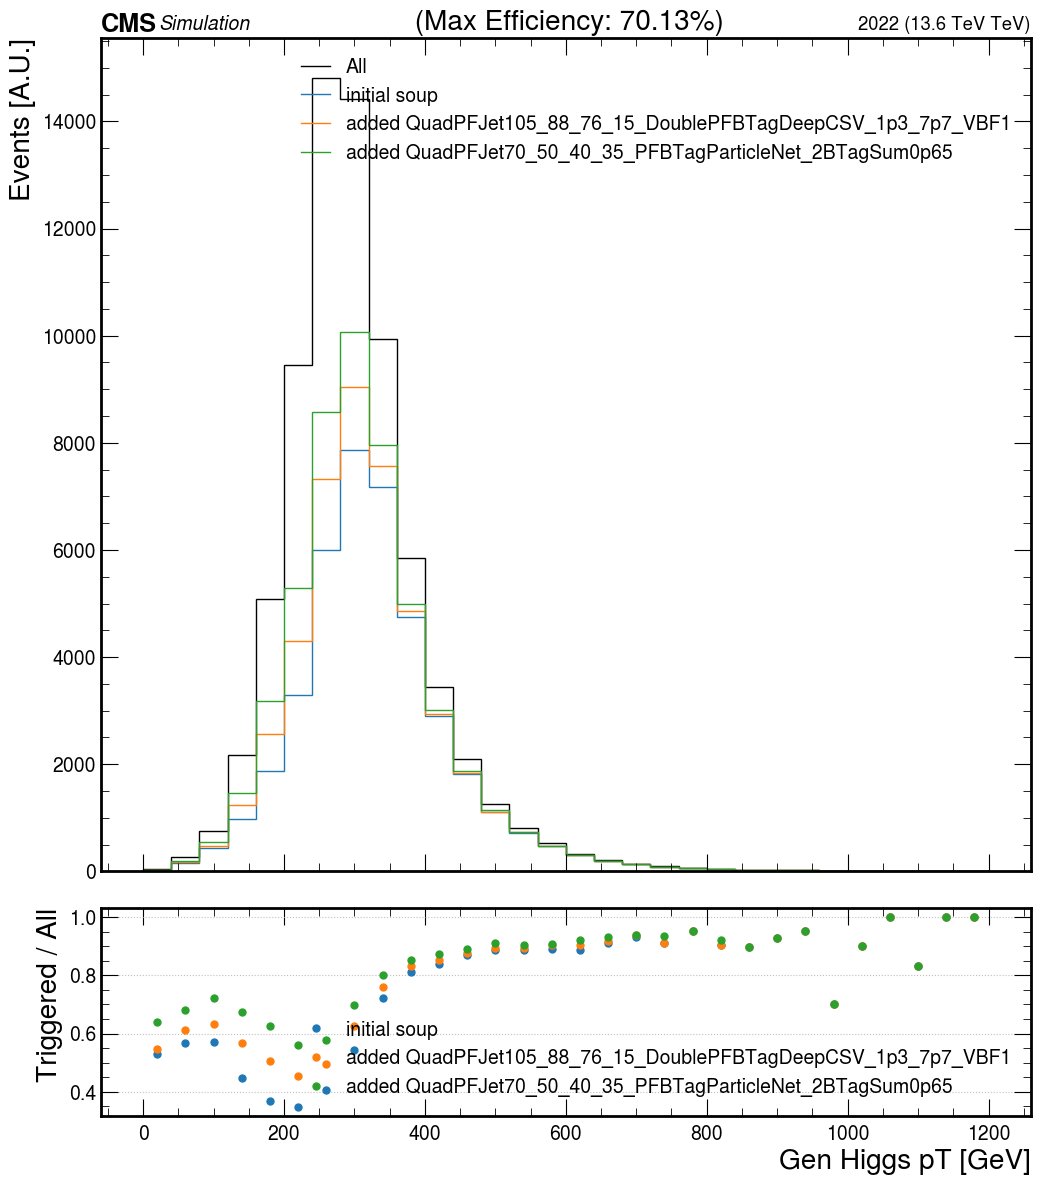

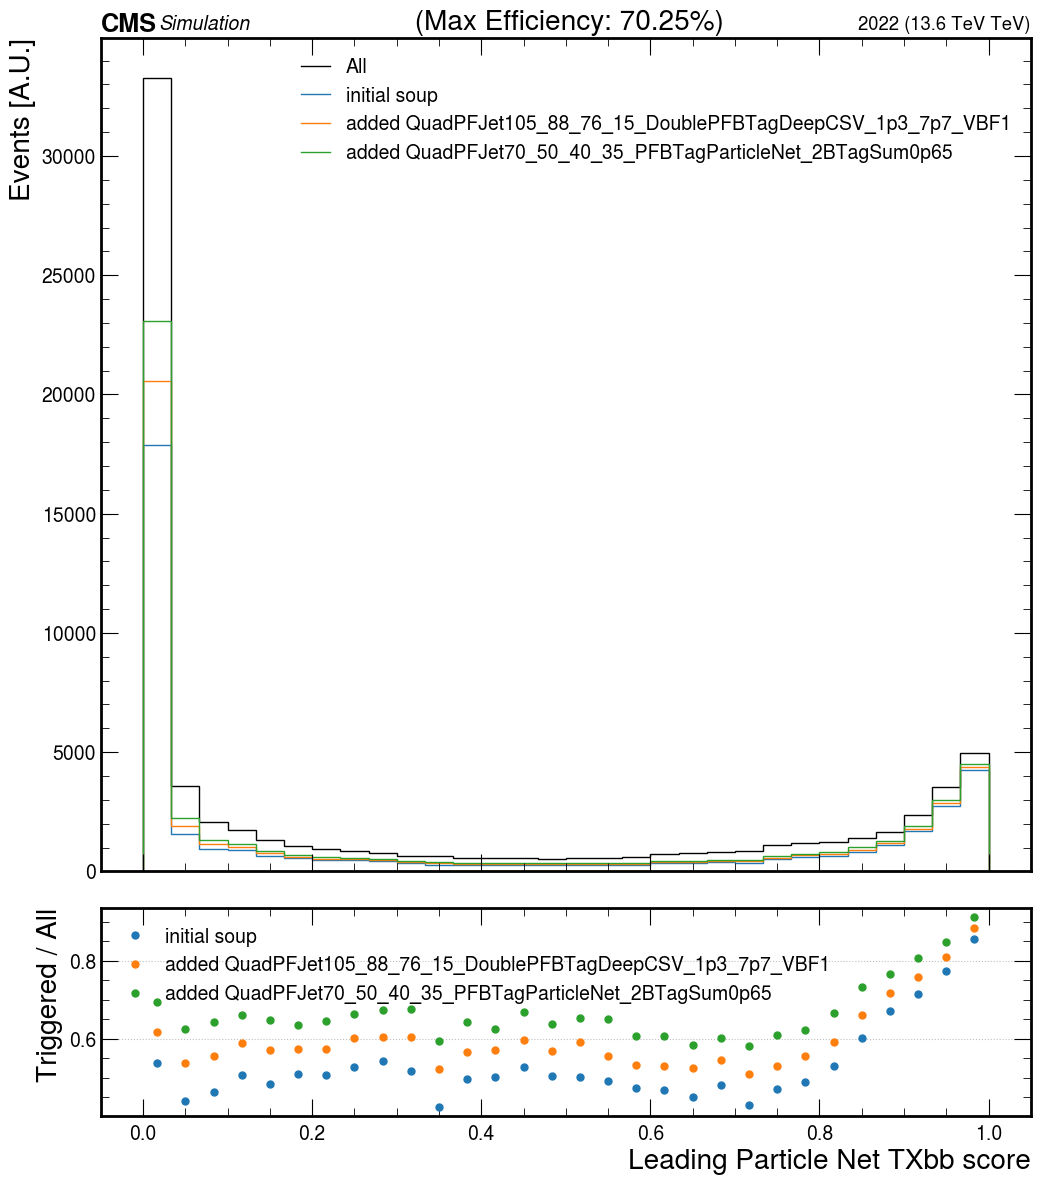

In [4]:
init_soup = ['AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35', 'AK8PFJet230_SoftDropMass40']
triggers_to_add = ['QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1', 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65']
file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
outputs = {key_prod: [] for key_prod in file_dict.keys()}
baseline_key = "general"
for prod_mode, file_name in file_dict.items():
    print("Currently processing production mode", prod_mode)
    with open(f'/srv/2022/2022_{prod_mode}.json', 'r') as file:
        data = json.load(file)
    samples = data[file_name]
    if prod_mode == 'ggF':
        samples = samples[:64]
    iterative_run = processor.Runner(
            executor = processor.FuturesExecutor(compression=None, workers=2),
            schema=NanoAODSchema,
            skipbadfiles=True,  # Skip files that fail to open
            savemetrics=True,   # Save metrics to understand where failures occur
    )
    fileset = {"Dataset" : samples}
    out = iterative_run(
        fileset,
        treename="Events",
        processor_instance=TriggerSoupProcessor(init_soup, triggers_to_add, trig_vars, baseline_key=baseline_key),
    )
    output = out[0]
    outputs[prod_mode] = output

    save_dir = f"/srv/figures/new/{baseline_key}_baseline/{prod_mode}/1d_trigger_soup"
    plot_1d_trigger_soup_cms(output, trig_vars, tags=['initial soup', 'added QuadPFJet105_88_76_15_DoublePFBTagDeepCSV_1p3_7p7_VBF1', 'added QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65'], save_dir=save_dir)
    